## Using Micrograd for Digit Recognition

Today we will try to train a neural network with micrograd that can recognize digits from the MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#importing our custom library
from Micrograd.engine import Value
from Micrograd.nn import Neuron, Layer, MLP, Module

In [2]:
#let's import the data using pandas -> then we can turn it into a numpy array
dig_data = pd.read_csv("MNIST_Train.csv")
dig_data = np.array(dig_data)

In [3]:
dig_data.shape

(42000, 785)

As we can see the imported data is a massive matrix of 42000x785. We need to break this data down.

Each row represents a single image. The first column contains all the labels as to what number that image represents

In [4]:
#make our results more reproducible by setting random seed
np.random.seed(1337)

In [5]:
#Next we want to shuffle our data and then split it up. Want to shuffle around all the rows
np.random.shuffle(dig_data) #shuffles in-place

#testing set will be of size 1000
Y_test = dig_data[:1000,0]
X_test = dig_data[:1000,1:]
X_test = X_test / 255

Y_train = dig_data[1000:,0]
X_train = dig_data[1000:,1:]
X_train = X_train / 255

#lets store the number of training examples into a variable called m
m_train = X_train.shape[0]
m_train

41000

8


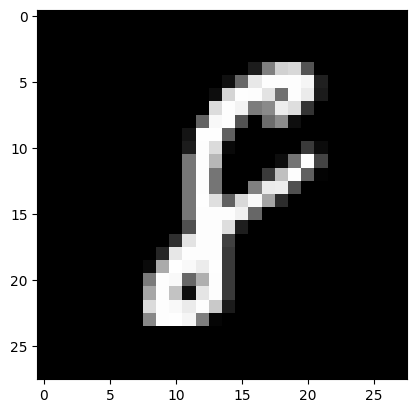

In [6]:
#Let's try to draw up one of the rows of X_train with matplotlib and make sure that the image matches up with the label
index = np.random.randint(0,m_train) 

img = (X_train[index, :, None] * 255).reshape(28,28)

plt.imshow(img, cmap = 'gray')
plt.show

print(Y_train[index])

In [7]:
#Now let's initialize our neural network using micrograd
nn = MLP(784, [10,10,10])
print("number of parameters",len(nn.parameters()))

number of parameters 8070


Remember that in order to feed data forward in our neural network we need our inputs to be in the form of Value objects.

In order to convert each row of our numpy matrix to a row of Values we can use np.vectorize(), this takes in a method (in our case its Value.__init__) and turns it into a vectorized function that can be applied to each element within a numpy array

In [8]:
#Creating vectorized version of Value() that will work on entire numpy array (this is sort of like map(Value, python_list)
To_Val = np.vectorize(Value)

#we can call this function on the first row of X
nn_1st_inp = To_Val(X_train[0, :])

nn(nn_1st_inp)

[Value(data=-2.4601407450898263, grad=0),
 Value(data=-18.78384031756561, grad=0),
 Value(data=13.524954842973628, grad=0),
 Value(data=4.4653047796051135, grad=0),
 Value(data=-9.514971397461334, grad=0),
 Value(data=1.1703881332967392, grad=0),
 Value(data=-12.213768538862098, grad=0),
 Value(data=-5.530389103809711, grad=0),
 Value(data=-7.911619954299733, grad=0),
 Value(data=-0.49106457090295924, grad=0)]

Let's get the models base accuracy on our testing data based off of these randomized weights.

To do this we will first need to be able to convert any Y[i] to one-hot encoding (i.e a 10x1 vector of all zeros, except at index Y[i] where it's 1)

In [9]:
def to_one_hot_m(y): #y will be a number from 0 to 9
    return [Value(1) if i == y else Value(0) for i in range(10)]

def from_one_hot_m(one_hot_y): #returns a number from a one_hot encoded vector
    return max(range(len(one_hot_y)), key = lambda i:one_hot_y[i].data)


In [10]:
index = np.random.randint(0,m_train)

label = Y_train[index]
ohy = to_one_hot_m(label)
reobtained = from_one_hot_m(ohy)

print(label)
print(ohy)
print(reobtained)

2
[Value(data=0, grad=0), Value(data=0, grad=0), Value(data=1, grad=0), Value(data=0, grad=0), Value(data=0, grad=0), Value(data=0, grad=0), Value(data=0, grad=0), Value(data=0, grad=0), Value(data=0, grad=0), Value(data=0, grad=0)]
2


In [11]:
def getAcc(model, X_data = X_test, Y_data = Y_test):
    total_ex = Y_data.shape[0]
    total_correct = 0

    for i in range(total_ex):
        row = X_data[i,:]
        nn_out = model(row)
        if from_one_hot_m(nn_out) == Y_data[i]:
            total_correct += 1
    return total_correct / total_ex

getAcc(nn)

0.079

Initially we have a very low accuracy of only 8% 

Lets see what we can do to change this. First we will need a way to calculate loss. The training data is too large to find the loss over the entire thing. Instead we will have to use stochastic gradient descent with mini-batches to approximate the gradient of the loss function

However first I must point out a critical mistake I've made while constructing my model. For my activation I've been using sigmoid to simply squish all the outputs to be between 0 and 1 so I can treat them like probabilities. The problem is, that these are not probability, they don't all add up to 1 so our model is inaccurate at the logical level. In order to get the best results we should have the model give a linear output, and then apply something like the softmax function to it.

The Softmax function takes a vector of elements and returns a probability distribution.

In [106]:
#Takes vector of numbers, returns vector of probabilities
import math

def softmax(vector):
    denom = sum(math.exp(i.data) for i in vector) #this is numerical
    numerators = [math.exp(i.data) for i in vector] #these are numerical

    def _backward():
        self.grad += out.data*(1-out.data)*out.grad #derivative of softmax(xi) with respect to xi is softmax(xi)*(1-softmax(xi))

    probs = []
    for i in range(len(vector)):
        self = vector[i]
        out = Value(numerators[i]/denom, (vector[i], ), _op = 'softmax')
        out._backward = _backward
        probs.append(out)
    return probs
        

In [107]:
from Micrograd.draw import draw_dot

In [15]:
#Lets make sure our softmax is working correctly

a, b, c = Value(3), Value(2), Value(-1)

vector = [a,b,c]

probs = [val.softmax(vector) for val in vector]

y = probs[0]*probs[1]*probs[2]
y

Value(data=0.002529615601878868, grad=0)

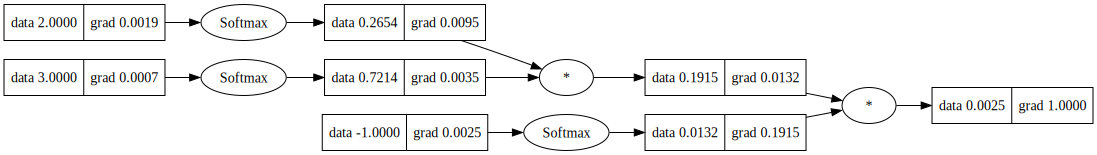

In [18]:
draw_dot(y)

In [17]:
y.backward()

In [59]:
#lets compare this to pytorch softmax
import torch

In [73]:
inp=torch.tensor([3,2,-1]).double()
inp.requires_grad = True

probs = torch.nn.functional.softmax(inp,dim=0)

print(probs)

tensor([0.7214, 0.2654, 0.0132], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)


In [74]:
#looks like our forward pass is good for softmax
y = torch.prod(probs)
print(y)

y.backward()

tensor(0.0025, dtype=torch.float64, grad_fn=<ProdBackward0>)


In [75]:
inp.grad

tensor([-0.0029,  0.0005,  0.0024], dtype=torch.float64)

In [48]:
#It looks like our softmax function isn't calculating gradients correctly. Lets just use sigmoid for now to just see what we can do with it

#We'll need a way to find the loss -> lets just use mean sqaure error
def mse_loss(model, batch_size):
    #get a bunch of random indices and put it into a list
    ri = np.random.permutation(m_train)[:batch_size]

    Xb,yb = To_Val(X_train[ri]),Y_train[ri]
    predictions,actual = [],[]

    #get all the predictions and all the actual values
    for i in range(len(Xb)):
        predictions.append(model(Xb[i]))
        actual.append(to_one_hot(yb[i]))

    losses = []
    
    #for each prediction the loss is the sum of all the squared losses
    for pred,actual in zip(predictions,actual):
        loss = sum((pred[i] - actual[i])**2 for i in range(len(pred)))
        losses.append(loss)

    return sum(losses)/len(losses) #get average of all the losses
    

mse_loss(nn,32)

Value(data=3.3454944762769903, grad=0)

In [50]:
#Now that we can get loss lets make a descent function
def descent(model,batch_size,num_steps):
    for k in range(num_steps):
        loss = mse_loss(model,batch_size)
        
        model.zero_grad()
        loss.backward()
        
        learning_rate = 0.1
        for p in model.parameters():
            p.data -= learning_rate*p.grad

        if k%25 == 0:
            print(f"step: {k}, loss: {loss.data}, accuracy: {getAcc(nn) *100}%")

In [55]:
descent(nn, 5, 200)

step: 0, loss: 0.621300327259827, accuracy: 41.0%
step: 25, loss: 0.733732472359752, accuracy: 41.0%
step: 50, loss: 1.064172696272161, accuracy: 39.0%
step: 75, loss: 0.41805934266594175, accuracy: 41.0%
step: 100, loss: 0.7982320246492957, accuracy: 39.0%
step: 125, loss: 0.9251171813062836, accuracy: 38.0%
step: 150, loss: 0.5788964270778124, accuracy: 42.0%
step: 175, loss: 0.8030421078133169, accuracy: 43.0%


In [56]:
descent(nn, 35, 100)

step: 0, loss: 0.6359232096399109, accuracy: 42.0%
step: 25, loss: 0.6383618273824933, accuracy: 42.0%
step: 50, loss: 0.6994849655912214, accuracy: 41.0%
step: 75, loss: 0.5511540721440962, accuracy: 42.0%


In [57]:
descent(nn, 50, 100)

step: 0, loss: 0.6682907901545447, accuracy: 42.0%
step: 25, loss: 0.6210965218771894, accuracy: 41.0%
step: 50, loss: 0.6568152791123262, accuracy: 43.0%
step: 75, loss: 0.6538115842514789, accuracy: 43.0%


After a lot of training (close to a 1000 steps) and a lot of time (~3 hours) our model only achieves 43% accuracy. This is likely because of problems such as:
 - Using sigmoid instead of softmax and therefore not having a proper probability distribution in the output layer
 - Using a very computationally inefficient scalar engine for a neural network with so many parameters
 - using very small batches and not doing a lot of steps because of the inefficiency and time it takes for training

## Using Vectorgrad for Digit Recognition

To resolve all of these problems I've made Vectorgrad which uses the underlying graph structure and simple API of a micrograd or pytorch but incorporates numpy and vector and matrix operations and calculus so that we can minimize the number of parameters in our model and do calculations in parallel to drastically decrease our compute time. The syntax for using is almost the same as before but now we have a Vector object rather than a value object (to be more accurate perhaps I should have called it a Tensor object but as of right some operations don't support tensors of a higher order than 2). 

In [12]:
#Lets now use our vectorized nn functions
from Vectorgrad import Vector
from Vectorgrad import Module, Layer, MLP
import numpy as np

In [13]:
new_nn = MLP(784, [10, 10, 10], [Vector.relu, Vector.relu, Vector.softmax])
print(new_nn)
print('Number of parameters: ', len(new_nn.parameters()))

MLP of [relu Layer(number of Neurons = 10), relu Layer(number of Neurons = 10), softmax Layer(number of Neurons = 10)]
Number of parameters:  6


In [15]:
[new_nn(X_train[i]) for i in range(3)] #testing feed forward of our network

[Vector(data=[ 0.  0.  0.  0. nan nan  0.  0.  0.  0.], grad=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 Vector(data=[0.0000000e+00 4.2963551e-05 2.0547289e-31 7.9594118e-34 2.7294144e-01
  7.2701550e-01 3.0497656e-30 0.0000000e+00 0.0000000e+00 4.1898824e-43], grad=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]),
 Vector(data=[ 0.  0.  0.  0.  0. nan  0.  0.  0.  0.], grad=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.])]

In [16]:
def to_one_hot(y): #y will be a number from 0 to 9
    encoded = np.zeros(10)
    encoded[y] = 1
    return Vector(encoded)

def from_one_hot(pred): #get the y value from a vector that is in one hot format
    return np.argmax(pred.data)

In [18]:
def getAccuracy(model, X = X_test, Y = Y_test):
    correct, num_ins = 0, X.shape[0]
    for i in range(num_ins):
        if Y[i] == from_one_hot(model(X[i])):
            correct+=1
    return correct/num_ins

getAccuracy(new_nn)

0.042

In [25]:
index = np.random.randint(0, m_train)
out = new_nn(X_train[index])
correct = to_one_hot(Y_train[index])

((out-correct)**2).sum()

Vector(data=1.5410032272338867, grad=0.0)

In [15]:
#We'll need a way to find the loss -> lets just use mean sqaure error
def mse_loss(model, batch_size, X = X_train, Y = Y_train):
    #get a bunch of random indices and put it into a list
    ri = np.random.permutation(m_train)[:batch_size]

    Xb,yb = X[ri],Y[ri]
    model_pred = [model(Xb[i]) for i in range(batch_size)] #Matrix or array of vectors
    actual_vals = [to_one_hot(yb[i]) for i in range(batch_size)]
    losses = []
    
    #for each prediction the loss is the sum of all the squared losses
    for pred,actual in zip(model_pred,actual_vals):
        loss = ((pred - actual)**2).sum() #we do element-wise subtraction and then raise to 2nd power then we sum up all the losses in the array to get a scalar
        if not np.isnan(loss.data): losses.append(loss)

    avg_loss = sum(losses)/batch_size
    return avg_loss #get average of all the losses

mse_loss(new_nn, 32) #sometimes we get nan, not sure why could be because of overflow/underflow
#I changed my function so that we disregard values that get us nan

Vector(data=1.780347466468811, grad=0.0)

In [48]:
def descent(model,batch_size,num_steps,loss_fn = mse_loss):
    for k in range(num_steps):
        loss = loss_fn(model,batch_size)
        
        model.zero_grad()
        loss.backward()
        
        learning_rate = 0.1
        for p in model.parameters():
            p.data -= learning_rate*p.grad

        if k%500 == 0:
            print(f"step: {k}, loss: {loss.data}, accuracy: {getAccuracy(model) *100}%")

In [16]:
descent(new_nn, 50, 5000)

step: 0, loss: 1.7279458045959473, accuracy: 6.0%
step: 25, loss: 1.8444972038269043, accuracy: 8.0%
step: 50, loss: 1.7423914670944214, accuracy: 8.0%
step: 75, loss: 1.3616341352462769, accuracy: 10.0%
step: 100, loss: 1.6750316619873047, accuracy: 14.000000000000002%
step: 125, loss: 1.6799017190933228, accuracy: 17.0%
step: 150, loss: 1.5622918605804443, accuracy: 18.0%
step: 175, loss: 1.5885342359542847, accuracy: 16.0%
step: 200, loss: 1.2761650085449219, accuracy: 17.0%
step: 225, loss: 1.5438363552093506, accuracy: 16.0%
step: 250, loss: 1.407946228981018, accuracy: 18.0%
step: 275, loss: 1.282869577407837, accuracy: 20.0%
step: 300, loss: 1.1974008083343506, accuracy: 22.0%
step: 325, loss: 1.1958634853363037, accuracy: 22.0%
step: 350, loss: 1.1446665525436401, accuracy: 22.0%
step: 375, loss: 1.0375326871871948, accuracy: 25.0%
step: 400, loss: 0.9061558246612549, accuracy: 25.0%
step: 425, loss: 0.9799529910087585, accuracy: 27.0%
step: 450, loss: 0.8422524929046631, accur

## Our new model is exponentially faster and is approaching better accuracy. Here are some possible reasons that it's not there yet:
1) We are using MSE which is not really the best loss function for multiple classification tasks like this, instead we should implement cross entropy loss
2) 2000 steps is likely nowhere near enough steps for our model to train on (also depends on batch size too)
3) Perhaps we need more neurons in the first or second layer or perhaps we should change up the activation functions used in each layer
4) We should also use algorithms to avoid overfitting such as L2 regularization

In [17]:
#Lets see our models accuracy on the training data -> 59% not bad
getAccuracy(new_nn, X_train, Y_train)

0.6524343675417661

Lets now work to implement cross entropy loss

In [38]:
def cross_entropy_loss(model, batch_size, X = X_train, Y = Y_train, epsilon = 1e-10):
    ri = np.random.permutation(m_train)[:batch_size]

    Xb,yb = X[ri],Y[ri]
    model_pred = [model(Xb[i]) for i in range(batch_size)] #Matrix of vectors 
    actual_vals = [to_one_hot(yb[i]) for i in range(batch_size)]
    losses = []

    for pred, actual in zip(model_pred, actual_vals):
        log_probs = (pred + epsilon).log()
        log_probs *= actual
        cross_entropy = -log_probs.sum()
        if not np.isnan(cross_entropy.data) and not np.isinf(cross_entropy.data): losses.append(cross_entropy)

    avg_loss = sum(losses)/batch_size
    assert isinstance(avg_loss, Vector)
    return avg_loss

In [46]:
#Will need to create a new model since log() was not part of Vector class before
#After a bit of experimentation I've found that a two layer network is much better for some reason than a three layer network
model2 = MLP(784, [10, 10], [Vector.tanh, Vector.softmax]) 
print(cross_entropy_loss(model2,50))
print(cross_entropy_loss(model2,100))


Vector(data=4.74130916595459, grad=0.0)
Vector(data=4.833046913146973, grad=0.0)


Right now we are having an issue because our loss function is sometimes returning a loss with data = -inf

The cause of this is likely numerical instability for when we calculate the cross entropy loss. When we call pred.log() inside the function sometimes this can take the log of a negative number or 0 which can result in weirdness. A common trick to avoid this problem is to add a small epsilon to the probability vector before taking its logarithm

In [47]:
#Lets now run descent with the new model using cross entropy loss for 5000 steps 
#(thats how many new_nn has used to get to 67% right now)

descent(model2, 32, 5000, loss_fn = cross_entropy_loss)

step: 0, loss: 4.946059703826904, accuracy: 7.000000000000001%
step: 50, loss: 2.8334858417510986, accuracy: 17.0%
step: 100, loss: 1.7484899759292603, accuracy: 19.0%
step: 150, loss: 2.4760754108428955, accuracy: 23.0%
step: 200, loss: 1.9044179916381836, accuracy: 31.0%
step: 250, loss: 1.7274059057235718, accuracy: 32.0%
step: 300, loss: 1.8769373893737793, accuracy: 30.0%
step: 350, loss: 2.326725721359253, accuracy: 31.0%
step: 400, loss: 1.5514445304870605, accuracy: 33.0%
step: 450, loss: 1.891198754310608, accuracy: 37.0%
step: 500, loss: 1.5463694334030151, accuracy: 40.0%
step: 550, loss: 1.8329941034317017, accuracy: 44.0%
step: 600, loss: 1.466937780380249, accuracy: 45.0%
step: 650, loss: 1.4544670581817627, accuracy: 47.0%
step: 700, loss: 1.7295666933059692, accuracy: 46.0%
step: 750, loss: 1.4784690141677856, accuracy: 48.0%
step: 800, loss: 1.6154508590698242, accuracy: 48.0%
step: 850, loss: 1.1131739616394043, accuracy: 51.0%
step: 900, loss: 1.0886684656143188, acc

As we can see, using cross entropy loss is much more efficient for our model. So far the best results I have gotten is training a 2-layer network (first layer using sigmoid and second layer using softmax) for 5000 steps with a batch_size of 32. This achieved an accuracy of 83% on test data. Lets try one more time with a two layer network that trains for 20000 steps to see if we can achieve an even better accuracy.

In [49]:
model3 = MLP(784, [16, 10], [Vector.relu, Vector.softmax])

In [50]:
descent(model3, 40, 20000, loss_fn = cross_entropy_loss)

step: 0, loss: 14.317644119262695, accuracy: 14.000000000000002%
step: 500, loss: 1.3867179155349731, accuracy: 56.00000000000001%
step: 1000, loss: 0.9786850214004517, accuracy: 68.0%
step: 1500, loss: 0.916029155254364, accuracy: 70.0%
step: 2000, loss: 0.49325117468833923, accuracy: 74.0%
step: 2500, loss: 0.7676650285720825, accuracy: 78.0%
step: 3000, loss: 0.9640111327171326, accuracy: 81.0%
step: 3500, loss: 0.6982080340385437, accuracy: 79.0%
step: 4000, loss: 0.6893267035484314, accuracy: 73.0%
step: 4500, loss: 0.26148825883865356, accuracy: 82.0%
step: 5000, loss: 0.765138566493988, accuracy: 83.0%
step: 5500, loss: 0.8037636876106262, accuracy: 82.0%
step: 6000, loss: 0.39003023505210876, accuracy: 82.0%
step: 6500, loss: 0.3556559383869171, accuracy: 82.0%
step: 7000, loss: 0.6000338196754456, accuracy: 80.0%
step: 7500, loss: 0.4652116000652313, accuracy: 82.0%
step: 8000, loss: 0.5040671825408936, accuracy: 84.0%
step: 8500, loss: 0.4210887849330902, accuracy: 82.0%
step

In [52]:
#Lets see what the final accuracy was for the testing data:
print('final testing accuracy: ', getAccuracy(model3)*100)

#And for the training data:
print('final training accuracy: ', getAccuracy(model3, X = X_train, Y = Y_train)*100)

final testing accuracy:  91.0
final training accuracy:  89.47971360381861


Not bad at all. Looks like we have finally solved the MNIST digit recognition challenge with nothing but numpy and our own custom libraries and functions!!!